In [ ]:
%pip install -U dataclocklib

In [1]:
import calendar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import dataclocklib
from dataclocklib.charts import dataclock
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator

# EDA Tutorial

This guide will carry out basic exploratory data analysis (EDA) of road safety data for 2019 - 2023. This data details the circumstances of personal injury road collisions in Great Britain for the last 5 years.

**NOTE**: This tutorial is a work in progress and will include other EDA techniques in an attempt to better demonstrate how dataclocklib can be incorporated into the visualisation of temporal patterns and an EDA workflow.

## Data information

- **Published by**: Department for Transport
- **Last updated**: 28 November 2024 
- **Topic**: Transport
- **Licence**: Open Government Licence

The statistics relate only to personal injury collisions on public roads that are reported to the police, and subsequently recorded, using the [STATS19](https://assets.publishing.service.gov.uk/media/60d0cc548fa8f57ce4615110/stats19.pdf) collision reporting form.

All the data variables are coded rather than containing textual strings. The lookup tables are available in the [road Safety Open Data Guide - 2024](https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-road-safety-open-dataset-data-guide-2024.xlsx)


In [2]:
raw_data = pd.read_csv(
    "https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-last-5-years.csv",
    dtype={"accident_index": "string", "accident_reference": "string"}
)

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520084 entries, 0 to 520083
Data columns (total 37 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               520084 non-null  string 
 1   accident_year                                520084 non-null  int64  
 2   accident_reference                           520084 non-null  string 
 3   location_easting_osgr                        519991 non-null  float64
 4   location_northing_osgr                       519991 non-null  float64
 5   longitude                                    519991 non-null  float64
 6   latitude                                     519991 non-null  float64
 7   police_force                                 520084 non-null  int64  
 8   accident_severity                            520084 non-null  int64  
 9   number_of_vehicles                           520084 non-nul

## Data Cleaning & Preprocessing

Below we assign appropriate data types and map a selection of coded values to their associated textual strings for further analysis.

In [4]:
data = raw_data.copy()

datetime_str = data["date"].str.cat(data["time"], sep=" ")
data["date_time"] = pd.to_datetime(datetime_str, yearfirst=False, dayfirst=True)

severity_map = dict(enumerate(["Fatal", "Serious", "Slight"], start=1))
data["accident_severity_str"] = data["accident_severity"].map(severity_map)

enhanced_severity_map = dict(
    enumerate(
        [
            "Fatal",
            "Very Serious",
            "Moderately Serious",
            "Less Serious",
            "Slight",
        ],
        start=1
    )
)

data["enhanced_severity_collision_str"] = data["enhanced_severity_collision"].map(enhanced_severity_map)

light_conditions_map = dict(
    zip(
        [1, 4, 5, 7, -1],
        [
            "Daylight",
            "Darkness (lights lit)",
            "Darkness (lights unlit)",
            "Darkness (no lighting)",
            "Darkness (lighting unknown)"
        ]
    )
)

data["light_conditions_str"] = data["light_conditions"].map(light_conditions_map)

road_surface_map = dict(
    enumerate(
        [
            "Dry",
            "Wet/damp",
            "Snow",
            "Frost/ice",
            "Flood (3cm+ deep)",
            "Oil/diesel",
            "Mud",
        ],
        start=1
    )
)

data["road_surface_conditions_str"] = data["road_surface_conditions"].map(road_surface_map)

weather_map = dict(
    enumerate(
        [
            "Fine (no high winds)",
            "Raining (no high winds)",
            "Snowing (no high winds)",
            "Fine (high winds)",
            "Raining (high winds)",
            "Snowing (high winds)",
            "Fog/mist",
            "Other",
            "Unknown",
        ],
        start=1
    )
)

data["weather_conditions_str"] = data["weather_conditions"].map(road_surface_map)

columns = {
    "date_time": "datetime64[ns]",
    "date": "string",
    "latitude": "float64",
    "longitude": "float64",
    "accident_index": "string",
    "number_of_casualties": "int32",
    "number_of_vehicles": "int32",
    "accident_severity": "int16",
    "accident_severity_str": "string",
    "enhanced_severity_collision": "int16",
    "enhanced_severity_collision_str": "string",
    "light_conditions": "int16",
    "light_conditions_str": "string",
    "road_surface_conditions": "int16",
    "road_surface_conditions_str": "string",
    "weather_conditions": "int16",
    "weather_conditions_str": "string",
}

data = data.reindex(columns=columns).astype(columns)

Here we check the completeness of the data, looking for any missing days. It is worth noting that 2020 was a leap year, giving 366 days.

In [5]:
(
    data
    # datetime index allows grouping by temporal frequency
    .set_index("date_time")
    .groupby(pd.Grouper(freq="YE"))
    ["date"]
    .nunique()
)

date_time
2019-12-31    365
2020-12-31    366
2021-12-31    365
2022-12-31    365
2023-12-31    365
Freq: YE-DEC, Name: date, dtype: int64

## Data Aggregation & Summary

Next, we will very briefly summarise and aggregate the data to look at the volume of casualties and accidents over the full 5 years, including the split across the accident severity categories.

'Fatal' accidents consistently show the highest standard deviation (from around 1.13 to 1.40), followed by 'Serious' accidents (0.79 to 0.97), and then 'Slight' accidents (0.62 to 0.68). This indicates that fatal accidents have the most variability in the number of casualties per accident, and accidents categorised as slight, are more consistent in their casualty counts.

### Fatal accidents 

The high standard deviations combined with means around 1.65-1.75 highlight a considerable variation in the number of casualties for fatal accidents. Some  involve single casualties, while others involve multiple, creating a wider spread. In 2023, we see the highest mean (1.75) and standard deviation (1.37), suggesting more multiple-casualty fatal accidents that year.

### Serious accidents

For this category, the values suggest more consistency in the number of casualties per accident. The variation is not as extreme as with the fatal accidents and the pattern has remained mostly consistent across the years.

### Slight accidents

The data indicates that slight accidents tend to be more consistent in their casualty counts. Most accidents of this nature involve one or two casualties, with less variation than the other severity categories.

In [6]:
summary_data = (
    data
    .set_index("date_time")
    .filter(
        [
            "accident_index",
            "accident_severity_str",
            "number_of_casualties"
        ]
    )
    .groupby([pd.Grouper(freq="YE"), "accident_severity_str"])
    .agg(
        accidents=pd.NamedAgg(column="accident_index", aggfunc="count"),
        casualties=pd.NamedAgg(column="number_of_casualties", aggfunc="sum"),
        casualties_mean=pd.NamedAgg(column="number_of_casualties", aggfunc="mean"),
        casualties_median=pd.NamedAgg(column="number_of_casualties", aggfunc="median"),
        casualties_std=pd.NamedAgg(column="number_of_casualties", aggfunc="std"),
    )
)

summary_data

accidents  casualties  casualties_mean  \
date_time  accident_severity_str                                           
2019-12-31 Fatal                       1658        2842         1.714113   
           Serious                    22980       31771         1.382550   
           Slight                     92898      118545         1.276077   
2020-12-31 Fatal                       1391        2175         1.563623   
           Serious                    18355       24495         1.334514   
           Slight                     71453       88914         1.244370   
2021-12-31 Fatal                       1474        2390         1.621438   
           Serious                    21284       28540         1.340913   
           Slight                     78329       97279         1.241928   
2022-12-31 Fatal                       1602        2656         1.657928   
           Serious                    23333       31948         1.369220   
           Slight                     81069      100876         1.244323   
2023-12-31 Fatal                       1522        2661         1.748357   
           Serious                    23438       31976         1.364280   
           Slight                     79298       98340         1.240132   

                                  casualties_median  casualties_std  
date_time  accident_severity_str                                     
2019-12-31 Fatal                                1.0        1.396281  
           Serious                              1.0        0.943921  
           Slight                               1.0        0.677882  
2020-12-31 Fatal                                1.0        1.126566  
           Serious                              1.0        0.836148  
           Slight                               1.0        0.620540  
2021-12-31 Fatal                                1.0        1.204417  
           Serious                              1.0        0.792897  
           Slight                               1.0        0.620187  
2022-12-31 Fatal                                1.0        1.185627  
           Serious                              1.0        0.864221  
           Slight                               1.0        0.625025  
2023-12-31 Fatal                                1.0        1.371884  
           Serious                              1.0        0.974518  
           Slight                               1.0        0.624091

This table is used to annotate bar charts with percentage labels.

In [7]:
def severity_percentage(data: pd.DataFrame) -> pd.DataFrame:
    """Calculate the percentage of accident and casualty totals per year,
    by accident severity category.

    Args:
        data (DataFrame): DataFrame to aggregate.

    Returns:
        DataFrame with 'accidents' & 'casualties' feature values calculated
        as a percentage.
    """
    return data.assign(
        accidents=lambda x: x["accidents"] / x["accidents"].sum() * 100,
        casualties=lambda x: x["casualties"] / x["casualties"].sum() * 100,
    )

summary_data_percent = (
    summary_data
    .filter(["accidents", "casualties"])
    .reset_index(level="accident_severity_str")
    .groupby(pd.Grouper(freq="YE"), as_index=False)
    .apply(severity_percentage)
    .round(2)
    .reset_index(level="date_time")
    .set_index(["date_time", "accident_severity_str"])
)

summary_data_percent

accidents  casualties
date_time  accident_severity_str                       
2019-12-31 Fatal                       1.41        1.86
           Serious                    19.55       20.74
           Slight                     79.04       77.40
2020-12-31 Fatal                       1.53        1.88
           Serious                    20.13       21.19
           Slight                     78.35       76.93
2021-12-31 Fatal                       1.46        1.86
           Serious                    21.06       22.26
           Slight                     77.49       75.88
2022-12-31 Fatal                       1.51        1.96
           Serious                    22.01       23.58
           Slight                     76.48       74.46
2023-12-31 Fatal                       1.46        2.00
           Serious                    22.48       24.05
           Slight                     76.06       73.95

## Traffic Accident Count by Severity 

Here we plot the summarised data for accidents categorised by accident severity. The Graph below shows the the number of traffic accidents by severity from 2019 - 2023. For each year, under 2% of casualties were fatal and the majority were categorised as 'Slight'.

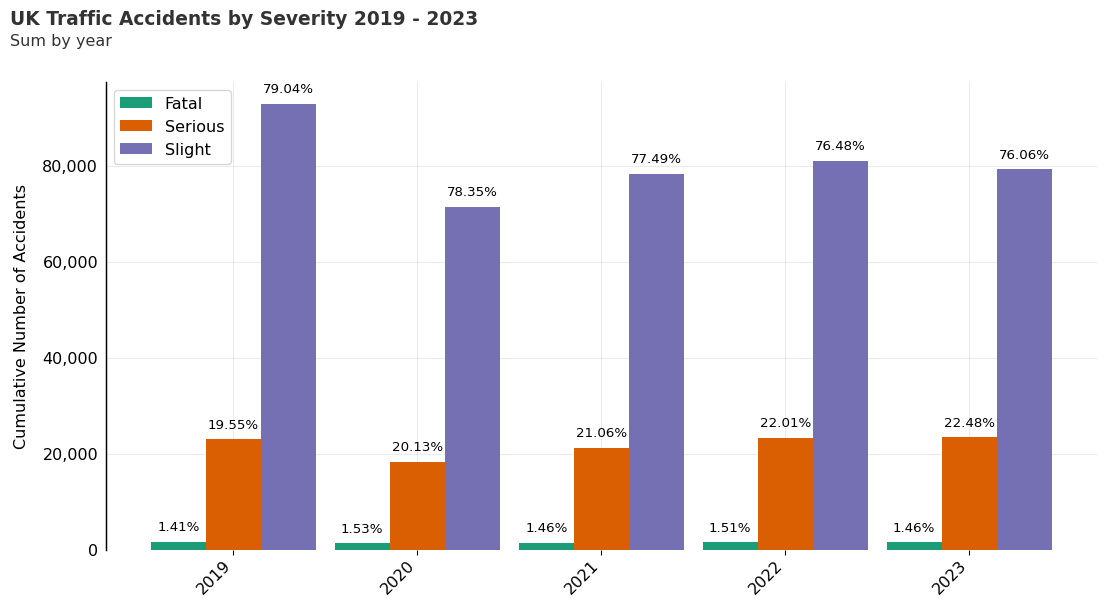

In [8]:
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)

# adjust subplots for custom title, subtitle and source text
plt.subplots_adjust(
    left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None
)

# Create the grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

ax.spines[["top", "right", "bottom"]].set_visible(False)
ax.spines['left'].set_linewidth(1.1)

# set white figure background
fig.patch.set_facecolor("w")

index_values = summary_data.index.get_level_values("date_time")
bar_x_positions = np.arange(index_values.nunique()) - 0.3
bar_x_labels = index_values.year.unique()
bar_width = 0.3

ax.set_ylabel("Cumulative Number of Accidents", fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_major_formatter(lambda s, i : f"{s:,.0f}")
ax.yaxis.set_tick_params(
    pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12
)

ax.set_xlabel("", fontsize=12, labelpad=10)
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12)
ax.xaxis.set_ticks(bar_x_positions + 0.3, bar_x_labels, rotation=45, ha="right")

cmap = plt.get_cmap("Dark2")

category_values = summary_data.index.get_level_values("accident_severity_str").unique()
for i, category in enumerate(category_values):
    bar_data = summary_data.loc[(slice(None), category), :]
    bar = ax.bar(
        bar_x_positions + (i*bar_width),
        bar_data["accidents"],
        width=bar_width,
        zorder=2,
        color=cmap(i),
        label=category
    )

    bar_data_pct = summary_data_percent.loc[(slice(None), category), :]
    ax.bar_label(
        bar,
        labels=map(lambda x: f"{x:.2f}%", bar_data_pct["accidents"]),
        padding=6,
        color="black",
        fontsize=10,
    )

ax.legend(loc="best", fontsize=12)

ax.text(
    x=0.05,
    y=.93,
    s="UK Traffic Accidents by Severity 2019 - 2023",
    transform=fig.transFigure,
    ha="left",
    fontsize=14,
    weight="bold",
    alpha=.8
)

ax.text(
    x=0.05,
    y=.90,
    s="Sum by year",
    transform=fig.transFigure,
    ha="left",
    fontsize=12,
    alpha=.8
)

plt.show()

## Traffic Accident Casualty Numbers by Severity 

In the graph below we plot the summarised data for casualties categorised by accident severity. The total number of casualties in 'Slight' accidents is the highest for each year, followed by 'Serious' and 'Fatal'.

Looking back at the 'summary_data' DataFrame, it is interesting to note that the average number of casualties in 'Fatal' accidents is higher than the average number of casualties in 'Slight' and 'Serious' accidents. More severe accidents not only tend to have more casualties on average but also show more variability in the number of casualties involved.

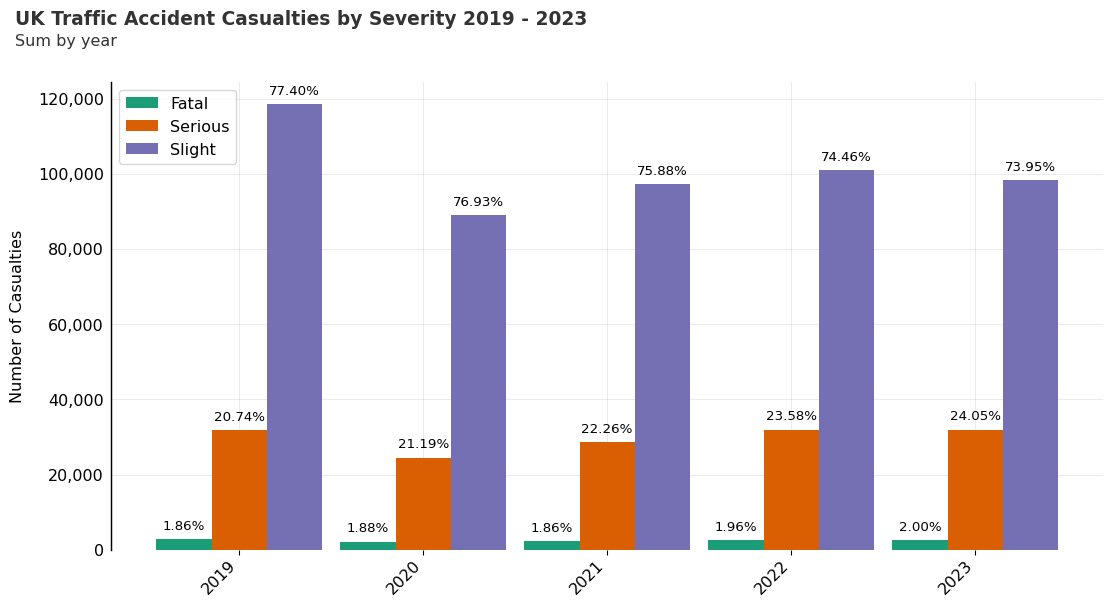

In [9]:
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)

# adjust subplots for custom title, subtitle and source text
plt.subplots_adjust(
    left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None
)

# Create the grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

ax.spines[["top", "right", "bottom"]].set_visible(False)
ax.spines['left'].set_linewidth(1.1)

# set white figure background
fig.patch.set_facecolor("w")

index_values = summary_data.index.get_level_values("date_time")
bar_x_positions = np.arange(index_values.nunique()) - 0.3
bar_x_labels = index_values.year.unique()
bar_width = 0.3

ax.set_ylabel("Number of Casualties", fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_major_formatter(lambda s, i : f"{s:,.0f}")
ax.yaxis.set_tick_params(
    pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12
)

ax.set_xlabel("", fontsize=12, labelpad=10)
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12)
ax.xaxis.set_ticks(bar_x_positions + 0.3, bar_x_labels, rotation=45, ha="right")

cmap = plt.get_cmap("Dark2")

category_values = summary_data.index.get_level_values("accident_severity_str").unique()
for i, category in enumerate(category_values):
    bar_data = summary_data.loc[(slice(None), category), :]
    bar = ax.bar(
        bar_x_positions + (i*bar_width),
        bar_data["casualties"],
        width=bar_width,
        zorder=2,
        color=cmap(i),
        label=category
    )

    bar_data_pct = summary_data_percent.loc[(slice(None), category), :]
    ax.bar_label(
        bar,
        labels=map(lambda x: f"{x:.2f}%", bar_data_pct["casualties"]),
        padding=5,
        color="black",
        fontsize=10,
    )

ax.legend(loc="best", fontsize=12)

ax.text(
    x=0.05,
    y=.93,
    s="UK Traffic Accident Casualties by Severity 2019 - 2023",
    transform=fig.transFigure,
    ha="left",
    fontsize=14,
    weight="bold",
    alpha=.8
)

ax.text(
    x=0.05,
    y=.90,
    s="Sum by year",
    transform=fig.transFigure,
    ha="left",
    fontsize=12,
    alpha=.8
)

plt.show()

## Temporal Factor Identification Using Dataclocklib

With this dataset, we might want to explore the data using different timescales. Below, we will summarise and aggregate the data by day of week and hour of day.

One assumption might be that the frequency of accidents is related to the time of day and that there are distinct trends for weekdays and weekends.

We might also want to investigate what contributes to multiple-casualty accidents, which are influencing the differences between the mean and median values highlighted in the 'summary_data' DataFrame.

In [10]:
dow_labels = tuple(calendar.day_name)

summary_data_dow = (
    data
    .set_index("date_time")
    .filter(["number_of_casualties"])
    .resample("1h")
    .agg(sum=pd.NamedAgg(column="number_of_casualties", aggfunc="sum"))
    .reset_index()
    .assign(day_of_week=lambda x: x["date_time"].dt.day_of_week)
    .assign(hour=lambda x: x["date_time"].dt.hour)
    .groupby(["day_of_week", "hour"])
    .agg(sum=pd.NamedAgg(column="sum", aggfunc="sum"))
    .reset_index(level="hour")
)

summary_data_dow

,hour,sum
day_of_week,,
0,0,1108
0,1,761
0,2,545
0,3,472
0,4,438
...,...,...
6,19,4291
6,20,3522
6,21,2914


## Total Accidents by Hour & Day of Week Chart

Here we create a basic line chart depicting hourly trends for each day of the week.

On the weekdays Monday to Thursday, the trend looks fairly consistent. We see a rise in accidents from 06:00 with a peak around 08:00, during the early morning commute.

Accidents fall by late morning, with another rise from 14:00 to 17:00, which is in line with the late afternoon commute. Friday morning starts off the same as the other weekdays, but around mid-morning, we see a notable increase in accident frequency, in comparison to the other weekdays.

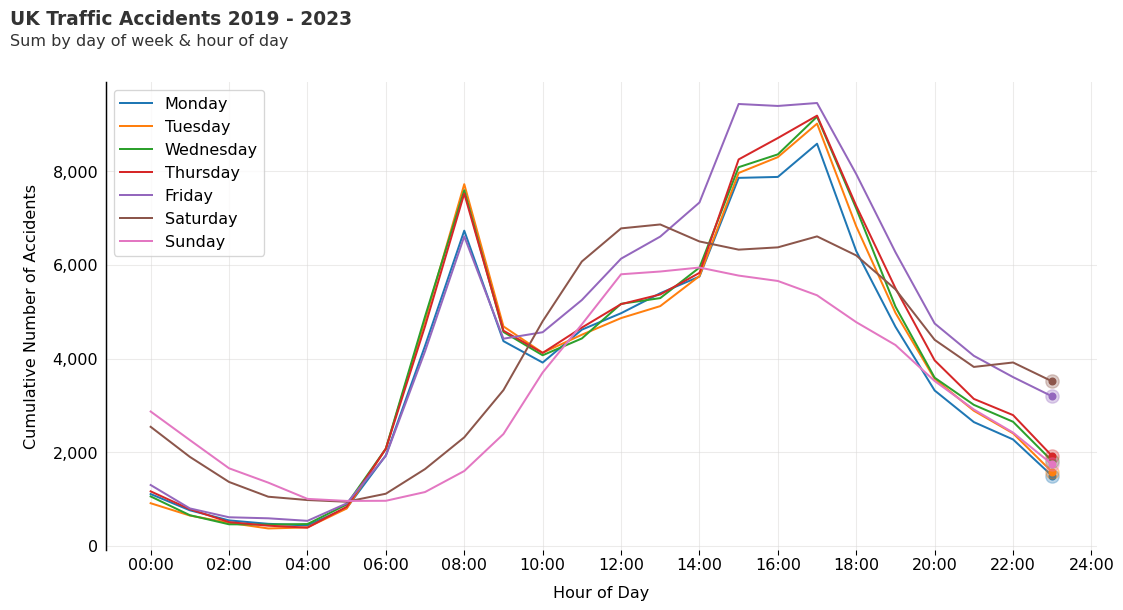

In [11]:
rcParams["font.family"] = "DejaVu Sans"

# create figure with polar projection
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)

# adjust subplots for custom title, subtitle and source text
plt.subplots_adjust(
    left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None
)

# set white figure background
fig.patch.set_facecolor("w")

# Create the grid
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

ax.spines[["top", "right", "bottom"]].set_visible(False)
ax.spines['left'].set_linewidth(1.1)

ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12)
ax.xaxis.set_major_formatter(lambda s, i : f"{int(s):02d}:00")
ax.xaxis.set_major_locator(MaxNLocator(23, integer=True))
ax.set_xlabel("Hour of Day", fontsize=12, labelpad=10)

ax.set_ylabel("Cumulative Number of Accidents", fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_major_formatter(lambda s, i : f'{s:,.0f}')
ax.yaxis.set_tick_params(
    pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12
)

cmap = plt.get_cmap("tab10")

for i in range(7):
    line_data = summary_data_dow.loc[i]
    line = ax.plot(
        line_data["hour"],
        line_data["sum"],
        color=cmap(i),
        label=dow_labels[i],
        zorder=2
    )

    ax.plot(
        line_data["hour"].iloc[-1],
        line_data["sum"].iloc[-1],
        "o",
        color=cmap(i),
        markersize=10,
        alpha=0.3
    )

    ax.plot(
        line_data["hour"].iloc[-1],
        line_data["sum"].iloc[-1],
        "o",
        color=cmap(i),
        markersize=5
    )

# Add legend
ax.legend(loc="upper left", fontsize=12)

ax.text(
    x=0.05,
    y=.93,
    s="UK Traffic Accidents 2019 - 2023",
    transform=fig.transFigure,
    ha="left",
    fontsize=14,
    weight="bold",
    alpha=.8
)

ax.text(
    x=0.05,
    y=.90,
    s="Sum by day of week & hour of day",
    transform=fig.transFigure,
    ha="left",
    fontsize=12,
    alpha=.8
)

plt.show()

## Dataclocklib Day of Week by Hour Chart

We will now utilise the dataclocklib library to demonstrate another way of visualising these temporal trends, using a data clock chart. Here, we use the day of week by hour of day mode ('DOW_HOUR') to split the data into temporal bins.

We see an initial spike from 0700 to 1000, which coincides with the daily morning commute. We see lower casualty figures for Saturday & Sunday (the two outer most rings), which is inline with our assumptions.

The majority of casualties occur 1200 to 1900 each day. In particular, we see higher numbers for Friday (3rd outermost ring) between 1500 - 1800.

Between 1700 and 1800 we see a temporal trend of increasing intensity over time from Monday - Friday. This is visually represented by a steady increase in darkness for this particular colour scheme. This trend is highlighted in a tabular form with the filtered DataFrame below.

In [12]:
# Monday - Friday casualty sum for 1700 shows increasing intensity
summary_data_dow.loc[0:4, :].query("hour.eq(17)")

,hour,sum
day_of_week,,
0,17,8590
1,17,9019
2,17,9168
3,17,9190
4,17,9460


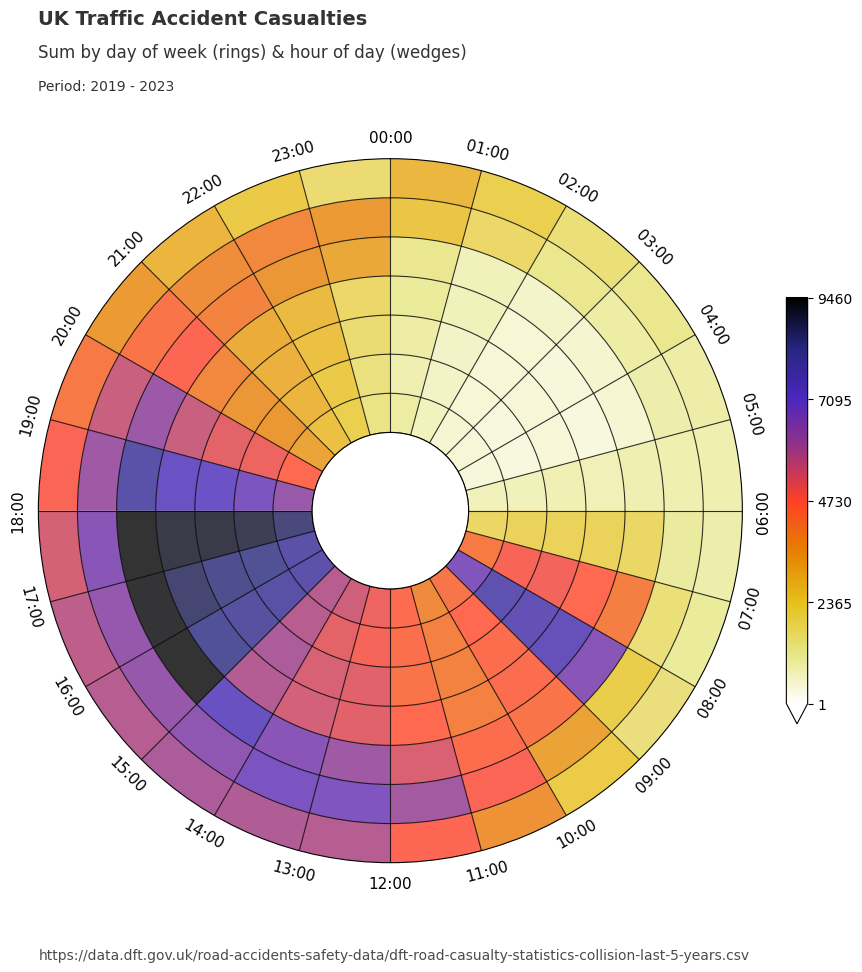

In [13]:
graph_data, fig, ax = dataclock(
      data=data,
      date_column="date_time",
      agg_column="number_of_casualties",
      agg="sum",
      mode="DOW_HOUR",
      cmap_name="CMRmap_r",
      chart_title="UK Traffic Accident Casualties",
      chart_subtitle=None, # use default (default_text=True)
      chart_period="Period: 2019 - 2023",
      chart_source="https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-last-5-years.csv",
      default_text=True
   )

We can also group the data by year and apply the chart function over the grouped data to see if these pattern remain consistent.

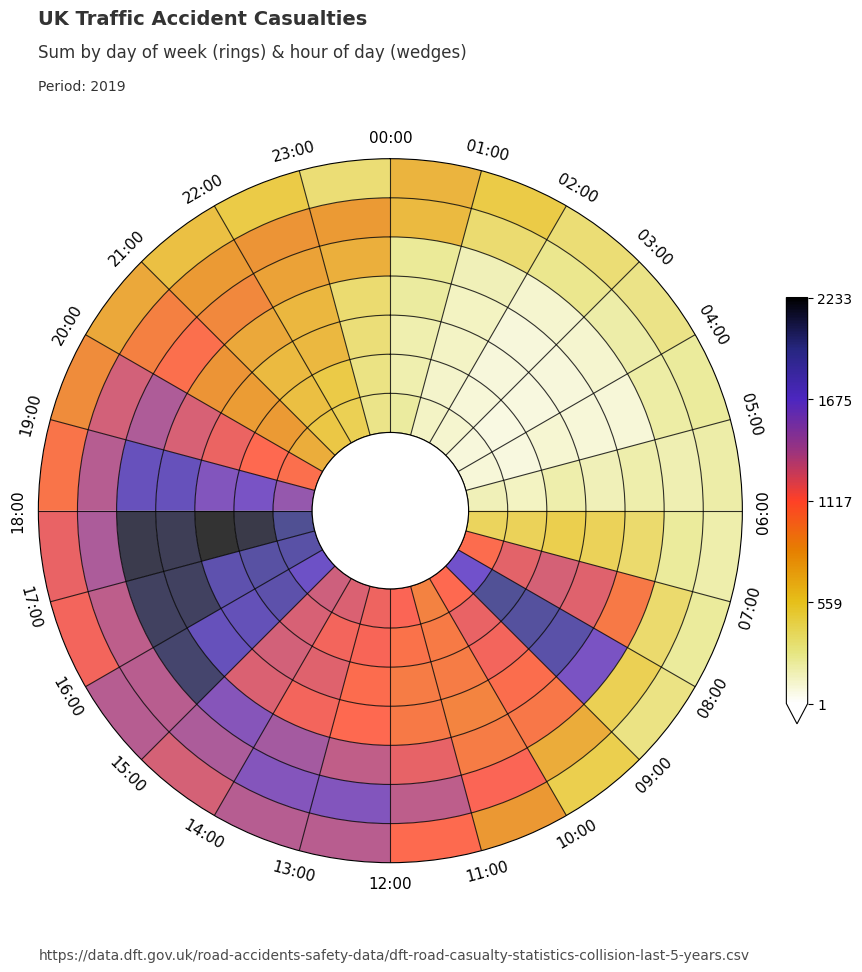

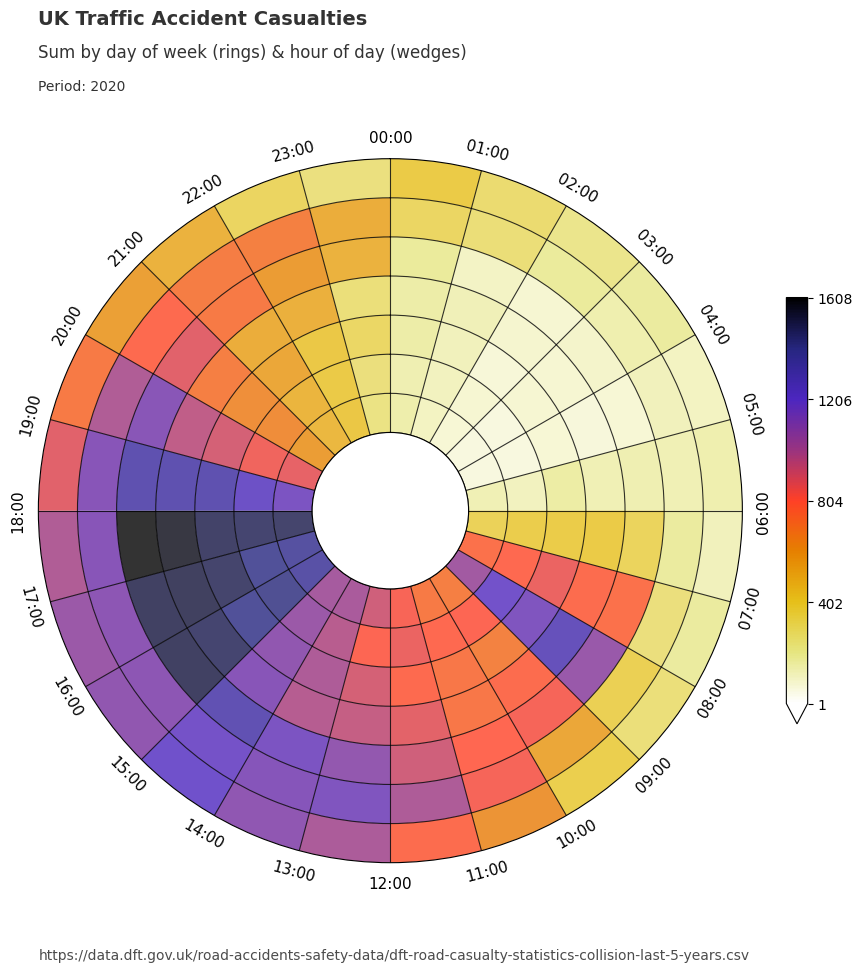

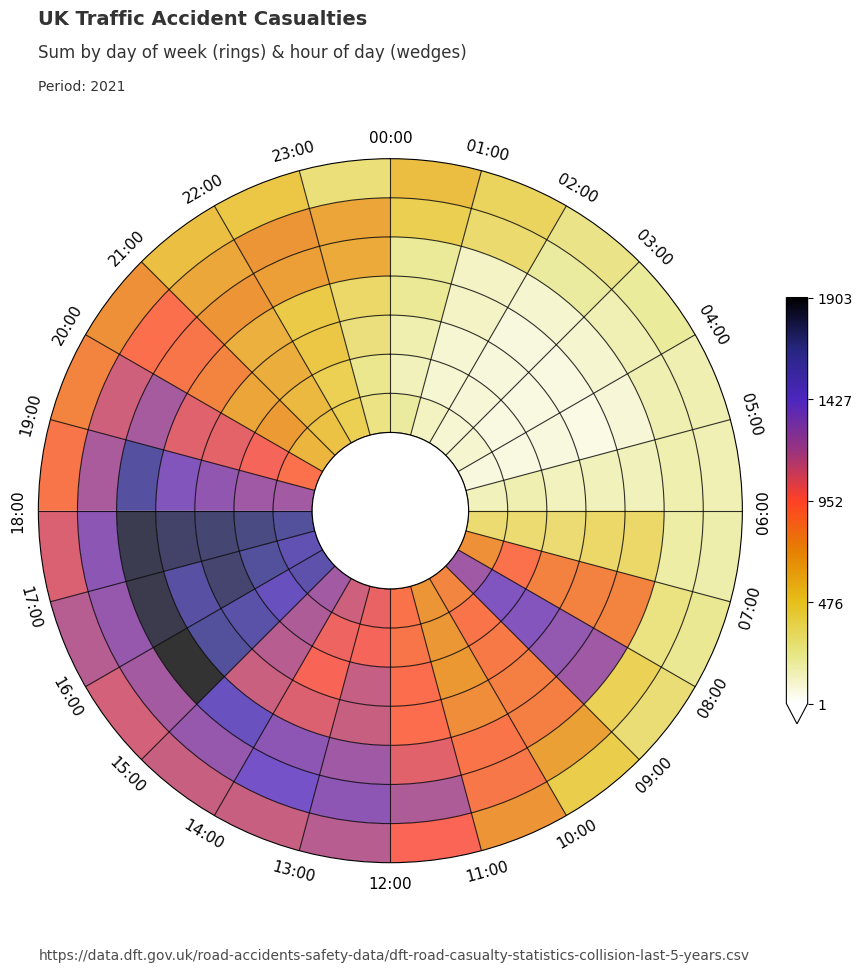

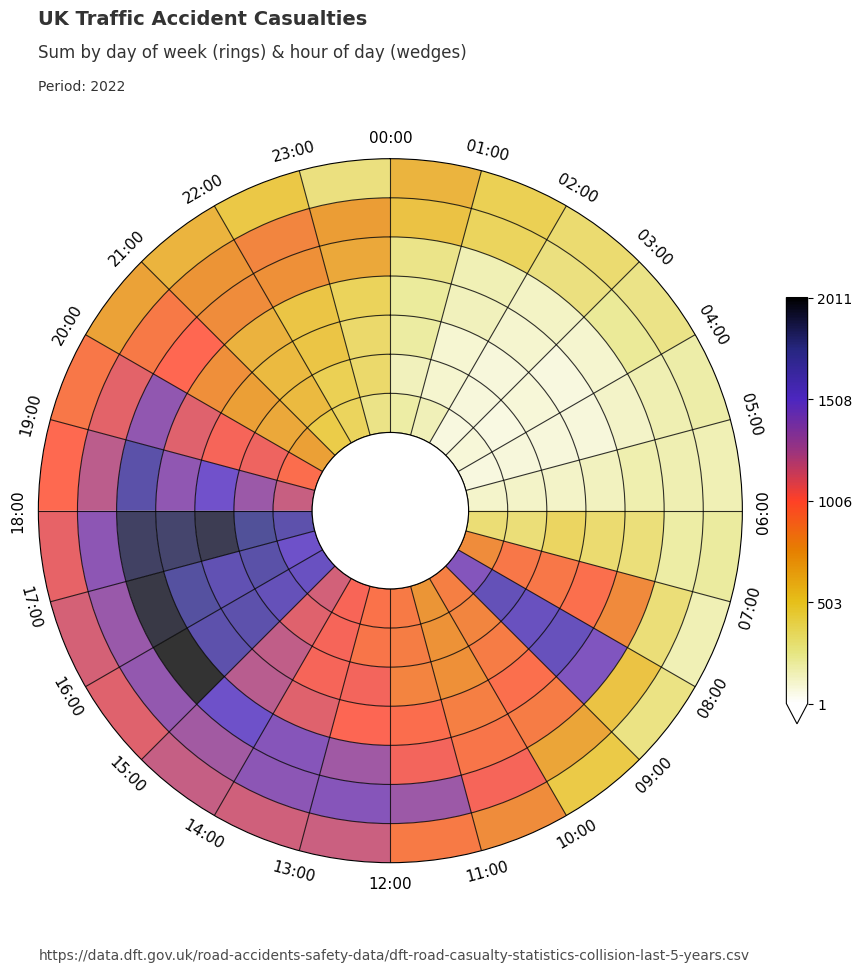

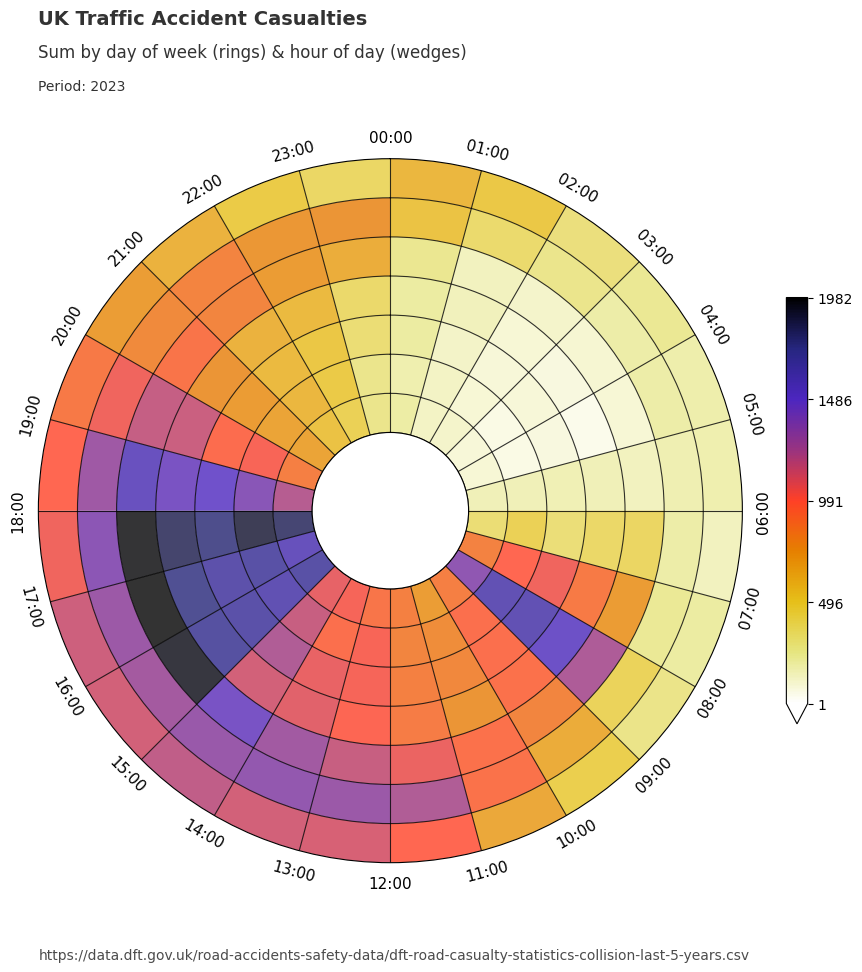

In [14]:
data_grouped = data.assign(year=lambda x: x["date_time"].dt.year).groupby("year")
for year, view in data_grouped:
      graph_data, fig, ax = dataclock(
            data=view,
            date_column="date_time",
            agg_column="number_of_casualties",
            agg="sum",
            mode="DOW_HOUR",
            cmap_name="CMRmap_r",
            chart_title=f"UK Traffic Accident Casualties",
            chart_subtitle=None,
            chart_period=f"Period: {year}",
            chart_source="https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-last-5-years.csv",
            default_text=True
      )

## Dataclocklib Accident Severity for Day of Week by Hour Chart

Below, we have grouped the data by accident severity to look for any distinguishable temporal patterns patterns. We have also changed the colour map to a traffic light style graduated colour scheme.

For fatal accidents we see larger numbers of casualties in certain time periods compared to slight and serious accidents. For example we see more intense patterns for Friday - Sunday between the hours of 2000 and 0200 than for the other categories.

Serious and slight categories show similar visual presentations, especially for the working day morning and afternoon commutes. You might also notice a higher distribution of serious accident casualties on weekends compared with those presented for the slight category.

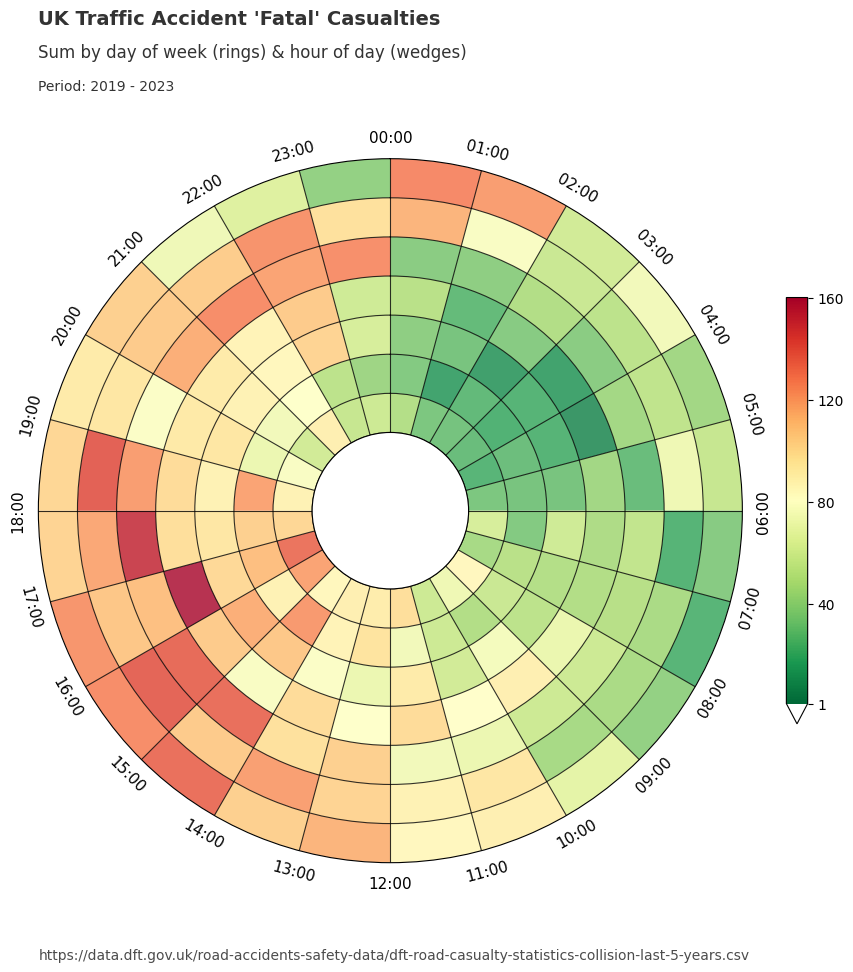

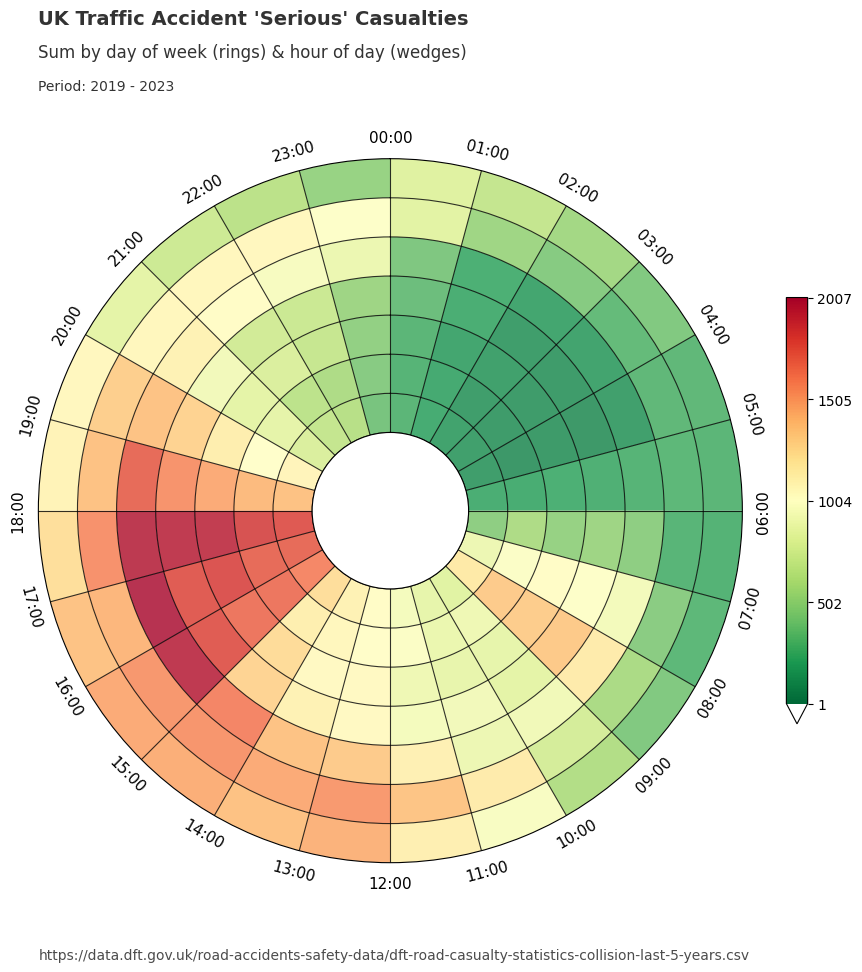

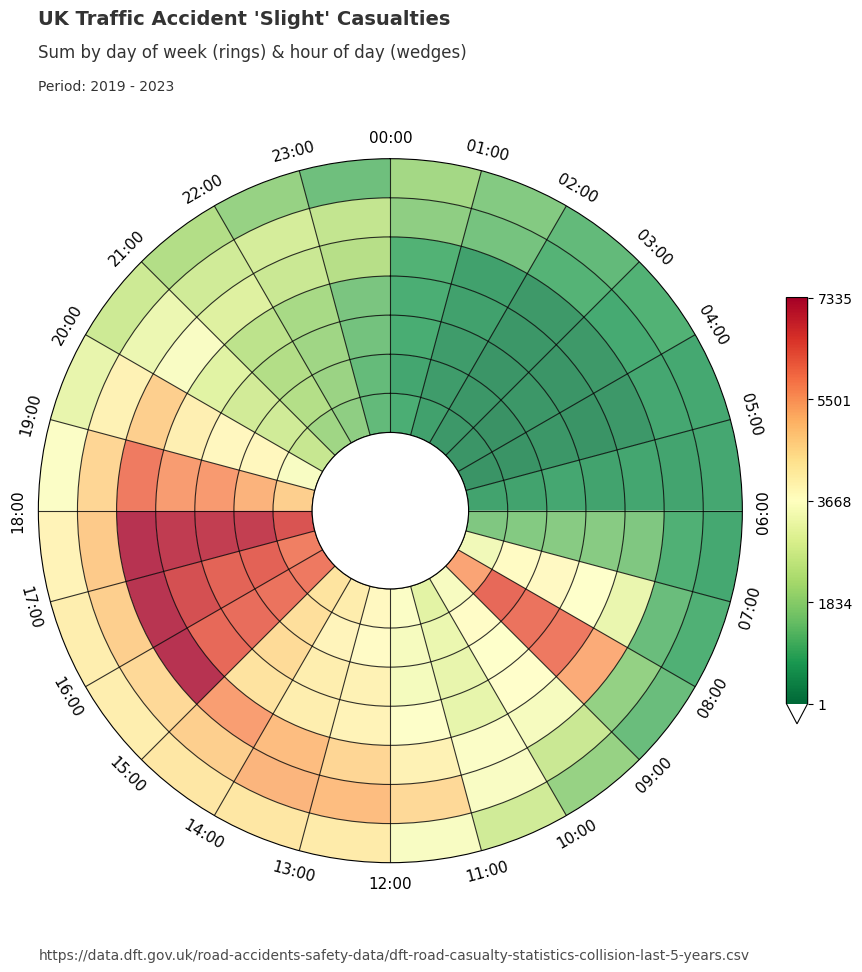

In [15]:
data_grouped = data.groupby("accident_severity_str")
for severity, view in data_grouped:
      graph_data, fig, ax = dataclock(
            data=view,
            date_column="date_time",
            agg_column="number_of_casualties",
            agg="sum",
            mode="DOW_HOUR",
            cmap_name="RdYlGn_r",
            chart_title=f"UK Traffic Accident '{severity}' Casualties",
            chart_subtitle=None,
            chart_period="Period: 2019 - 2023",
            chart_source="https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-last-5-years.csv",
            default_text=True
      )

## Dataclocklib Accident Severity for Year by Month Chart

Here we use the same data grouped by accident severity category and visualise in a data clock with years and months.

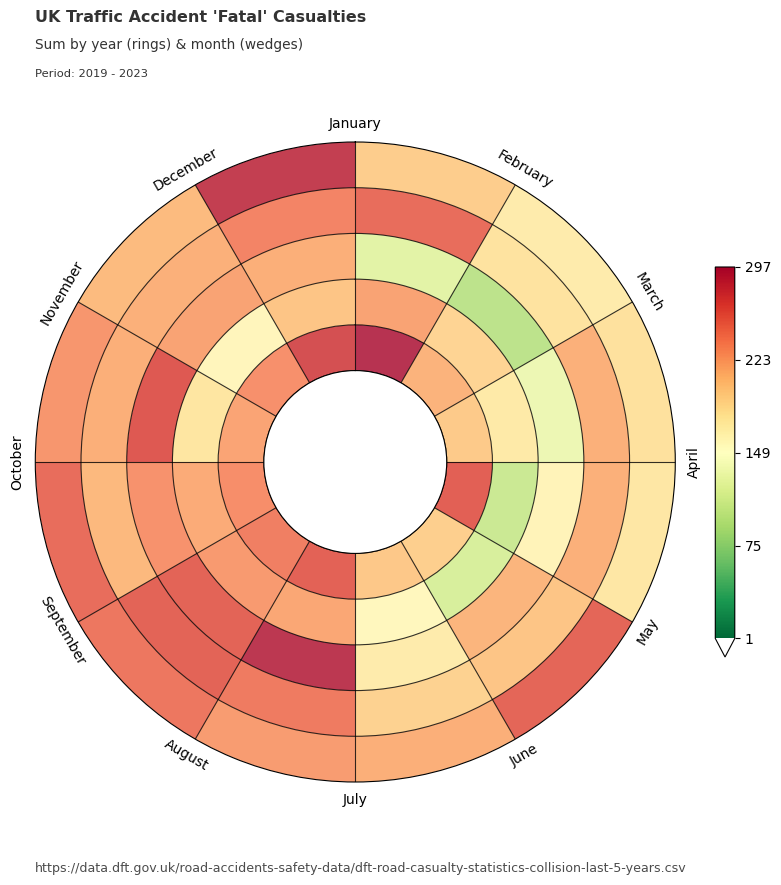

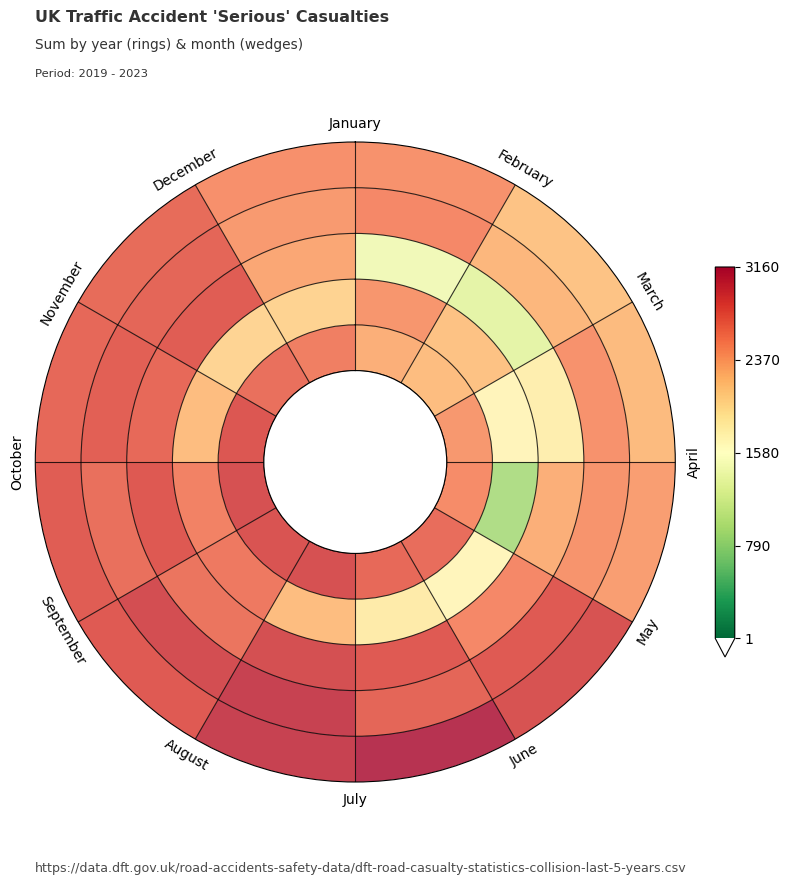

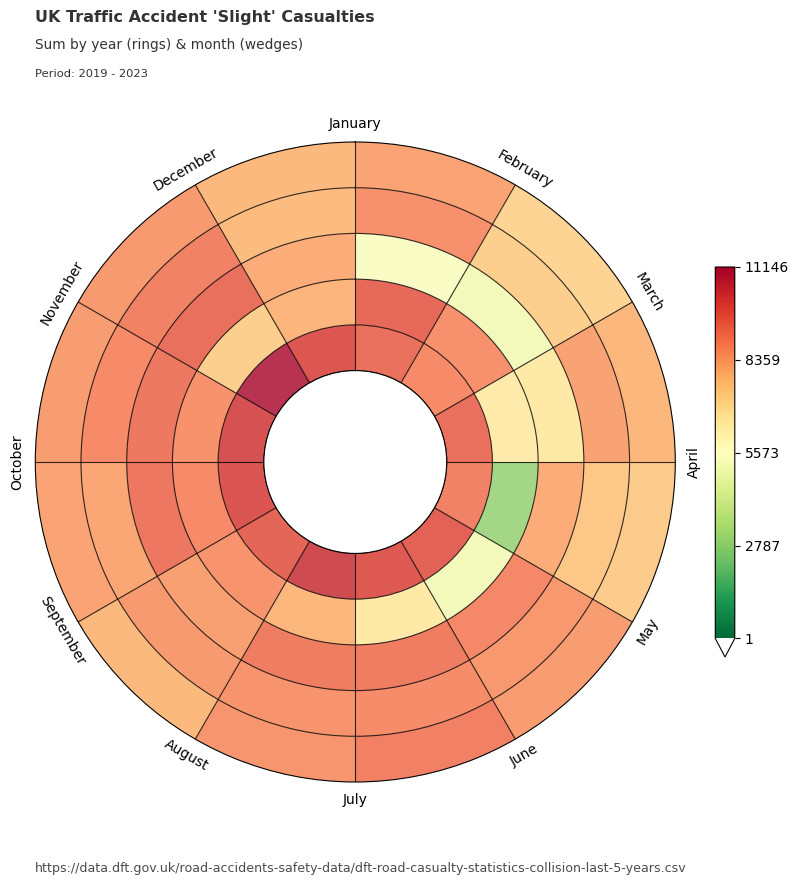

In [16]:
for severity, view in data_grouped:
    graph_data, fig, ax = dataclock(
        data=view,
        date_column="date_time",
        agg_column="number_of_casualties",
        agg="sum",
        mode="YEAR_MONTH",
        cmap_name="RdYlGn_r",
        chart_title=f"UK Traffic Accident '{severity}' Casualties",
        chart_subtitle=None,
        chart_period="Period: 2019 - 2023",
        chart_source="https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-last-5-years.csv",
        default_text=True
    )